This project aims to predict the movement of assets based on quantitative analysis and machine learning. This is an ongoing project. Data is collected from tdameritrade api, https://developer.tdameritrade.com.  Quantitative analysis techniques will be used to make predictions and then compared with machine learning techniques. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from api_key import api_key # api_key was saved in an api_key.py file

In [2]:
# # creating api url request

# symbol = input().upper()
# url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbol)


In [3]:
# refer to tdameritrade documentation for parameters.

payload = {'apikey': api_key,
          'periodType': 'year',
          'period': '20',
          'frequencyType': 'daily',
          'frequency': '1'}


# retrieving historically price function and returns a response string object

def historicalPrice(symbols):
    if isinstance(symbols, dict):
        price = {}
        for symbol in symbols.keys():
            url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbol)
            # extracting the response object into json format
            price[symbol] = requests.get(url, payload).json()
    else:
        url = 'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(symbols)
        price = requests.get(url, payload).json()
    return price

In [4]:
# converting miliseconds to datetime format. Also add additional day to get current date.

def daily_datetime(data):
    df = data
    df['date'] = df['datetime'].map(lambda x: datetime.fromtimestamp((x + 86400000) / 1000))
    df['date'] = df['date'].map(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
    return df

In [180]:
# Spider Sectors

sectors = {'XLC': 'Communication Services', 'XLY': 'Consumer Discretionary', 'XLP': 'Consumer Staples',
          'XLE': 'Energy', 'XLF': 'Financials', 'XLV': 'Health Care', 'XLI': 'Industrials', 'XLB': 'Materials',
          'XLRE': 'Real Estate', 'XLK': 'Technology', 'XLU': 'Utilities', 'MSOS': 'US Cannabis'}

In [142]:
# retrieving historical price of each sector.

sectorsPrice = historicalPrice(sectors)
os.system('say "Retrieving is done"')

0

In [215]:
# loading json dictionary into a dictionary of dataframes.

hp_df = {}
for sector in sectors.keys():
    hp_df[sector] = pd.json_normalize(sectorsPrice[sector], 'candles') # dataframe for each sector
    daily_datetime(hp_df[sector])

<BarContainer object of 1021 artists>

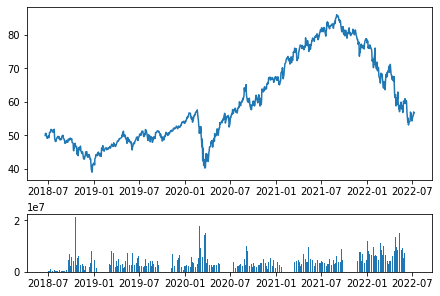

In [8]:
# plottinh using matplotlib 

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(4,4, fig)
ax_price = fig.add_subplot(gs[:3,:])
ax_vol = fig.add_subplot(gs[3,:])

x = hp_df['XLC']['date']
y_price = hp_df['XLC']['close']
#y_MA = hp_df['XLC']['MA5']
y_vol = hp_df['XLC']['volume']

ax_price.plot(x,y_price)
ax_vol.bar(x,y_vol)

In [9]:
# percent change

def percentChange(data):
    if isinstance(data, dict):
        for sector in data.keys():
            data[sector]['percent change'] = round((data[sector]['close']/data[sector]['close'].shift(1) - 1) * 100,2)
    else:
        data['percent change'] = round((data['close']/data['close'].shift(1) - 1) * 100,2)
    return data

In [10]:
percentChange(hp_df)

{'XLC':        open    high     low  close   volume       datetime       date  \
 0     49.70  50.060  49.580  49.96    16588  1529384400000 2018-06-19   
 1     50.45  50.889  50.450  50.58   189989  1529470800000 2018-06-20   
 2     50.77  50.850  50.200  50.27   428740  1529557200000 2018-06-21   
 3     50.59  50.610  50.190  50.49   181638  1529643600000 2018-06-22   
 4     50.23  50.230  49.015  49.45  2509603  1529902800000 2018-06-25   
 ...     ...     ...     ...    ...      ...            ...        ...   
 1016  54.08  54.890  53.705  54.82  4400436  1656651600000 2022-07-01   
 1017  54.13  56.120  53.610  56.09  4237414  1656997200000 2022-07-05   
 1018  56.09  56.545  55.492  56.10  4234945  1657083600000 2022-07-06   
 1019  56.27  57.210  56.120  56.98  3297224  1657170000000 2022-07-07   
 1020  56.45  57.130  56.170  56.71  2566941  1657256400000 2022-07-08   
 
       percent change  
 0                NaN  
 1               1.24  
 2              -0.61  
 3     

In [216]:
hp_df['XLK']

,open,high,low,close,volume,datetime,date
0,16.17,16.200,15.47,15.58,1090100,1026104400000,2002-07-08
1,15.56,15.760,15.31,15.35,397600,1026190800000,2002-07-09
2,15.45,15.560,14.94,14.94,907900,1026277200000,2002-07-10
3,14.85,15.490,14.68,15.49,1277900,1026363600000,2002-07-11
4,15.85,15.850,15.29,15.42,1111100,1026450000000,2002-07-12
...,...,...,...,...,...,...,...
5034,126.32,127.730,125.23,127.41,6965317,1656651600000,2022-07-01
5035,125.68,129.040,124.96,129.01,7170535,1656997200000,2022-07-05
5036,129.29,131.160,128.65,130.12,8083462,1657083600000,2022-07-06
5037,130.69,133.110,130.69,132.81,6541124,1657170000000,2022-07-07


In [225]:
'''
Moving Average

A simple moving average (SMA), the number of prices within a time period is divided by the number of total 
periods.Whereas An exponential moving average (EMA) places a greater weight and significance on the most recent data 
points. It is also referred to as the exponentially weighted moving average. An exponentially weighted moving average 
reacts more significantly to recent price changes than a SMA, which applies an equal weight to all observations in the period.

'''

def movingAverage(data, num_days, type = 'simple'):
    
    if isinstance(data, dict):
        for sector in data.keys():
            if type == 'simple':
                data[sector]['SMA{}'.format(num_days)] = data[sector]['close'].rolling(num_days).mean()
            else:
                data[sector]['EMA{}'.format(num_days)] = data[sector]['close'].ewm(span=num_days, adjust=False, min_periods=num_days+1).mean()
#                 EMA_y = data[sector]['close'].rolling(num_days).mean()
#                 weight = 2/(1+num_days)
#                 data[sector]['EMA{}'.format(num_days)] = data[sector]['close'].shift(num_days+1)*weight + EMA_y.shift(1)*(1-weight)
    else:
        if type == 'simple':
            data['SMA{}'.format(num_days)] = data['close'].rolling(num_days).mean()
        else:
            data['EMA{}'.format(num_days)] = data['close'].ewm(span=5, adjust=False, min_periods=num_days).mean()
        
    return data

In [229]:
movingAverage(hp_df, 10, 'exponential')

{'XLC':        open    high     low  close   volume       datetime       date  \
 0     49.70  50.060  49.580  49.96    16588  1529384400000 2018-06-19   
 1     50.45  50.889  50.450  50.58   189989  1529470800000 2018-06-20   
 2     50.77  50.850  50.200  50.27   428740  1529557200000 2018-06-21   
 3     50.59  50.610  50.190  50.49   181638  1529643600000 2018-06-22   
 4     50.23  50.230  49.015  49.45  2509603  1529902800000 2018-06-25   
 ...     ...     ...     ...    ...      ...            ...        ...   
 1016  54.08  54.890  53.705  54.82  4400436  1656651600000 2022-07-01   
 1017  54.13  56.120  53.610  56.09  4237414  1656997200000 2022-07-05   
 1018  56.09  56.545  55.492  56.10  4234945  1657083600000 2022-07-06   
 1019  56.27  57.210  56.120  56.98  3297224  1657170000000 2022-07-07   
 1020  56.45  57.130  56.170  56.71  2566941  1657256400000 2022-07-08   
 
            EMA5      EMA10  
 0           NaN        NaN  
 1           NaN        NaN  
 2           

In [231]:
hp_df['XLK'].head(20)

,open,high,low,close,volume,datetime,date,EMA5,EMA10
0,16.17,16.20,15.47,15.58,1090100,1026104400000,2002-07-08,NaN,NaN
1,15.56,15.76,15.31,15.35,397600,1026190800000,2002-07-09,NaN,NaN
2,15.45,15.56,14.94,14.94,907900,1026277200000,2002-07-10,NaN,NaN
3,14.85,15.49,14.68,15.49,1277900,1026363600000,2002-07-11,NaN,NaN
4,15.85,15.85,15.29,15.42,1111100,1026450000000,2002-07-12,NaN,NaN
5,15.10,15.72,14.76,15.72,548700,1026709200000,2002-07-15,15.499424,NaN
6,15.50,16.04,15.41,15.54,1004900,1026795600000,2002-07-16,15.512949,NaN
7,16.30,16.30,15.45,15.65,1817000,1026882000000,2002-07-17,15.558633,NaN
8,15.51,15.82,15.30,15.32,369300,1026968400000,2002-07-18,15.479089,NaN
9,15.07,15.36,14.64,14.84,1419600,1027054800000,2002-07-19,15.266059,NaN
